In [1]:
## Tabla de contenidos

In [3]:
import pandas as pd
import geopandas
import shapely
import pysal
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# !pip install pysal

In [16]:
# https://data.buenosaires.gob.ar/dataset/colectivos-paradas
# https://data.buenosaires.gob.ar/dataset/colectivos-recorridos
# https://data.buenosaires.gob.ar/dataset/informacion-censal-por-radio/archivo/juqdkmgo-1214-resource

# Geodatos y transporte

Sin lugar a dudas el entorno urbano es el lugar predilecto para los análisis con datos vectoriales y, además, el transporte es una de las fuentes de información más atractivas. No sólo por su riqueza como información en sí sino también por la relevancia del transporte en la vida cotidiana en las grandes ciudades, especialmente en América Latina donde el transporte suele ser un problema en sí mismo.

Es así que encontramos todo tipo de información en este rubro:

- Polígonos estáticos como barrios o jurisdicciones administrativas (educativas, por ej.) o censales (como radio o fracción censal en Argentina).

- Líneas o multilíneas estáticas como las rutas de los colectivos o el callejeros de la ciudad.

- Puntos estáticos como paradas de colectivos, estaciones de subtes y trenes.

- Puntos en tiempo real como la posición de colectivos, camiones de basura, cortes de tránsito, accidentes, etc.

## Cargamos datos

Vamos a leer la información. Noten que en todos los casos vamos a usar WGS 84.

In [5]:
def from_wkt(df, wkt_column, crs='EPSG:4326'):
    
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads) # empleamos una función de shapely para leer WKT
        
    gdf = geopandas.GeoDataFrame(barrios, geometry='coordinates', crs=crs) # seteamos la columna de geometría
    
    return gdf

Es común que los archivos shapefile incluyan la información sobre el sistema de coordenadas empleado. Esta información se encuentra incluida en el archivo .prj

In [11]:
recorridos = geopandas.read_file("recorrido-colectivos/recorrido-colectivos.shp")

In [12]:
recorridos.crs.name

'WGS 84'

In [13]:
paradas = geopandas.read_file("paradas-de-colectivo-zip/paradas-de-colectivo.shp")

In [14]:
paradas.crs.name

'WGS 84'

In [15]:
barrios = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/barrios.csv", encoding='latin1')

In [16]:
barrios = from_wkt(barrios, "WKT")

In [17]:
barrios.crs.name

'WGS 84'

In [18]:
radios = geopandas.read_file("informacion-censal-por-radio-2010/informacion_censal_por_radio_2010.shp")

In [19]:
radios.crs.name

'WGS 84'

## Analizando polígonos

Un problema común suele ser tener una ruta o un callejero mucho más grande que el área que necesitamos analizar, por ejemplo, una ciudad, un barrio o una región delimitada arbitrariamente.

Para comenzar veamos las rutas de colectivos en el Área Metropolitana de Buenos Aires.

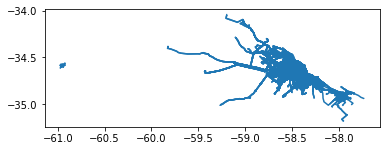

In [47]:
recorridos.plot()

Ok, eso no nos dice demasiado... Sí podemos ver que hay a la izquierda una serie de rutas que no está muy claro qué son... Filtrémoslas y volvamos a plotear. Para ello vamos a quedarnos con las rutas al este de la longitud -60.5.

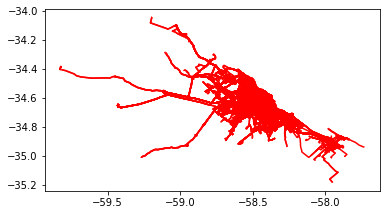

In [64]:
recorridos_amba = recorridos[recorridos.geometry.centroid.x > -60.5]
recorridos_amba.plot(color="red")

Bueno, ahora que filtramos se vé más prolijo pero, ¿qué estamos viendo realmente? Para entender un poco mejor qué estamos viendo sumemos la capa de barrios de capa y grafiquemos.

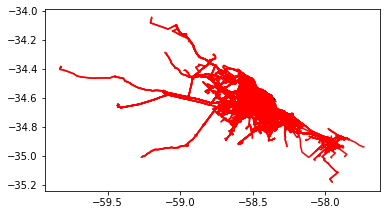

In [65]:
fig, ax = plt.subplots()
recorridos_amba.plot(ax=ax, color="red")
barrios.plot(ax=ax, color="black")
plt.show()

Mmm no podemos ver nada, ¿qué podemos hacer? El método plot incluye un parámetro alpha que regula la opacidad de la misma. Ajustando eso vamos a tener un mejor resultado. Además, vamos a agrandar la imagen para poder verla mejor.

In [73]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

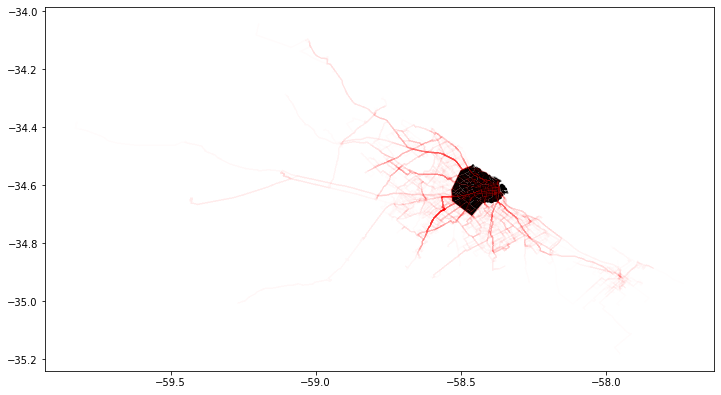

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
recorridos_amba.plot(ax=ax, color="red", alpha=0.008)
barrios.plot(ax=ax, color="black")
plt.show()

Ok, ahora sí podemos notar que las rutas exceden en mucho la ciudad de Buenos Aires. Para trabajar con esta información va a ser conveniente reducir el tamaño de las rutas sólo a la ciudad de Buenos Aires.

## Usando máscaras

Es común que es situaciones nos encontremos con que un polígono es demasiado grande para lo que necesitamos o que excede en tamaño a otro polígono. En estos casos vamos a tener que "cortar" un polígono para reducirlo al tamaño y forma necesarios.

Para poder usar los polígonos de CABA vamos a comenzar uniendo los barrios en un solo polígono (en vez de tener un polígono por barrio nos vamos a quedar con un solo polígono de todo CABA). Recordando la clase pasada, para hacer eso necesitamos agregar una columna constante, en este caso "ciudad" que sólo va a tener el valor "CABA" y luego aplicar **disolve**.

In [76]:
barrios["ciudad"] = "CABA"
mascara = barrios.dissolve(by="ciudad")

A continuación podemos "clipear" la capa de recorridos con la máscara.

In [77]:
recorridos_caba = geopandas.clip(recorridos, mascara)

/home/usuario/anaconda3/envs/geopandas_env/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


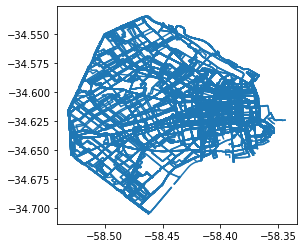

In [21]:
recorridos_caba.plot()

In [ ]:
# hablar de ax = plt.subplots  vs mapa =radios.plot

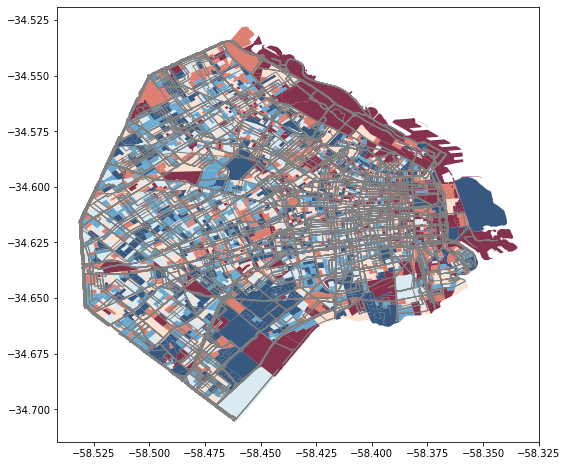

In [44]:
# https://matplotlib.org/tutorials/colors/colormaps.html
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))
radios.plot(ax=ax, column="POBLACI", linewidth=0.03, cmap="RdBu", scheme="quantiles", k=6, alpha=0.8)
recorridos_caba.plot(ax=ax, color="grey", linewidth=1)
plt.show()

In [28]:
# https://automating-gis-processes.github.io/site/notebooks/L5/static_maps.html
# Remove the empty white-space around the axes
plt.tight_layout()

NameError: name 'plt' is not defined

<Figure size 432x288 with 0 Axes>